这是我对于Unet和attention_YNet的尝试，试着把Ynet用到的处理方式应用到Unet上。

这是第一部分,包含了:
基础导入和工具函数
图像处理类(填充/还原)
数据集类
数据加载器创建函数

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

# 自定义的函数模块
from functions.data import prepare_dataset
from functions.model import UNet
from functions.data import SegmentationDataset



In [ ]:
train_data, test_data = prepare_dataset("VNC") # Lucchi++ /  Kasthuri++ / VNC
PATCH_SIZE = 128 #这个暂时不需要理会，和下面的内容没关系
# # Path to the chest-ct-segmentation dataset folder
# data_dir = "dataset\Lucchi++" 
# train_images_dir = os.path.join(data_dir, "Train_In")
# train_masks_dir = os.path.join(data_dir, "Train_Out")
# test_images_dir = os.path.join(data_dir, "Test_In")
# test_masks_dir = os.path.join(data_dir, "Test_Out")


# i = 0
# # Prepare the training data, Append image and corresponding mask paths
# train_data = []
# for image_file in os.listdir(train_images_dir):
#     image_path = os.path.join(train_images_dir, image_file)
#     mask_path = os.path.join(train_masks_dir, f"{i}.png")
#     i += 1
#     train_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })

# i = 0
# # Prepare the test data, Append image and corresponding mask paths
# test_data = []
# for image_file in os.listdir(test_images_dir):
#     image_path = os.path.join(test_images_dir, image_file)
#     mask_path = os.path.join(test_masks_dir, f"{i}.png")
#     i += 1
#     test_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })
# print(train_data)



Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

In [3]:
# 创建数据集
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=128,                # 可选：patch大小，默认128
    stride=128,                     # 可选：滑动步长，默认64
    transform=None,
    # preProcessing= None# 可选：数据增强转换，默认None
)

# test_dataset= SegmentationDataset(
#     data_list=train_data,          # 必需：数据列表
#     patch_size=128,                # 可选：patch大小，默认128
#     stride=64,                     # 可选：滑动步长，默认64
#     transform=None                 # 可选：数据增强转换，默认None
# )


数据集信息:
总样本数: 13260
图像块大小: 128x128
滑动步长: 128
是否使用数据增强: 否

数据形状:
图像块形状: torch.Size([3, 128, 128])
掩码块形状: torch.Size([1, 128, 128])

显示图片的patches: mask1073.png
原图路径: dataset\Kasthuri++\Train_In\mask1073.png
对应的Mask路径: dataset\Kasthuri++\Train_Out\mask1073.png
图片索引: 42


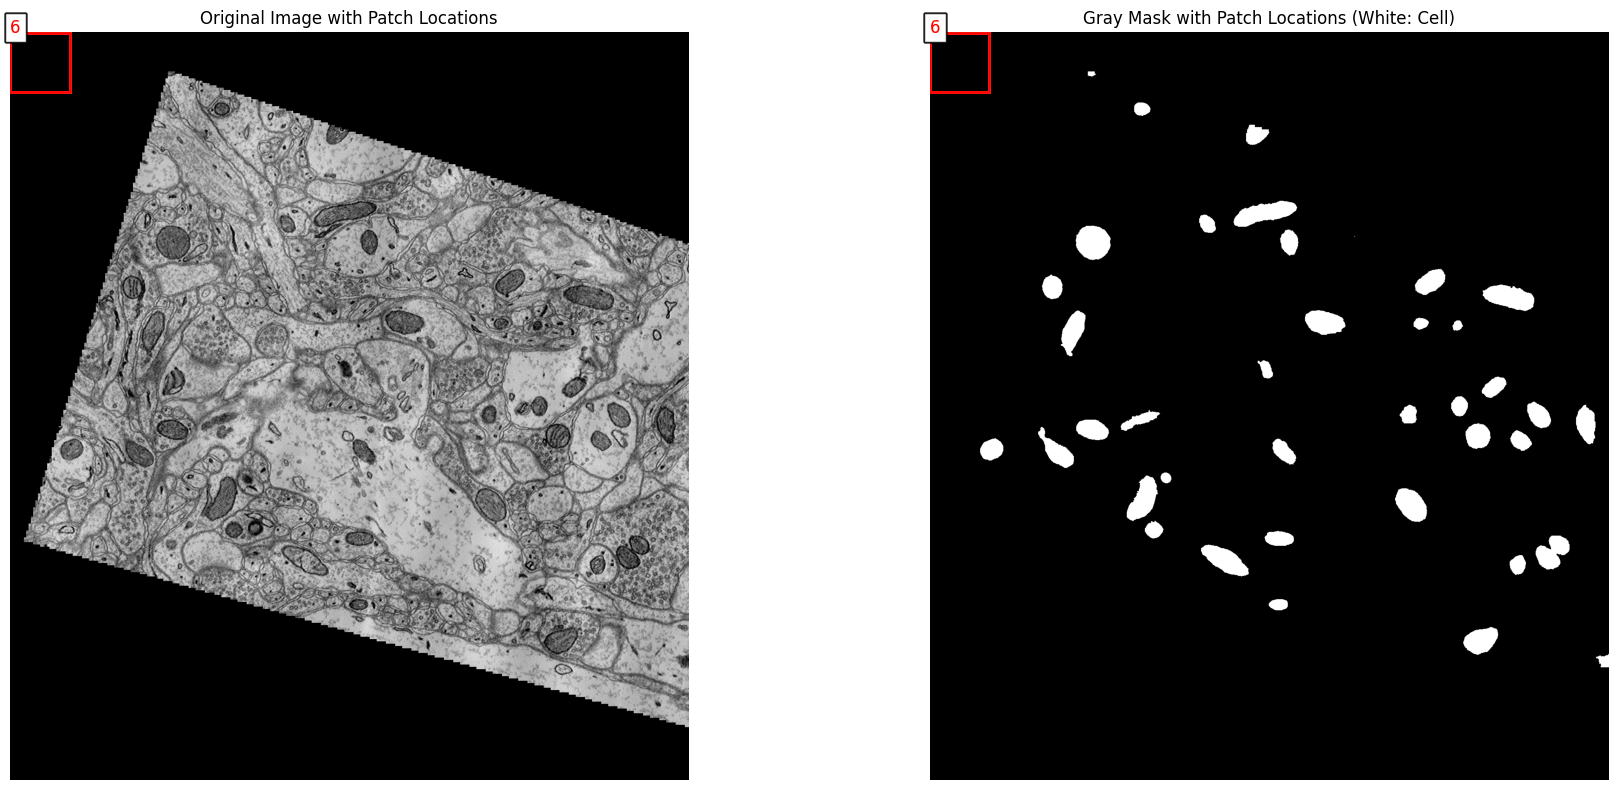

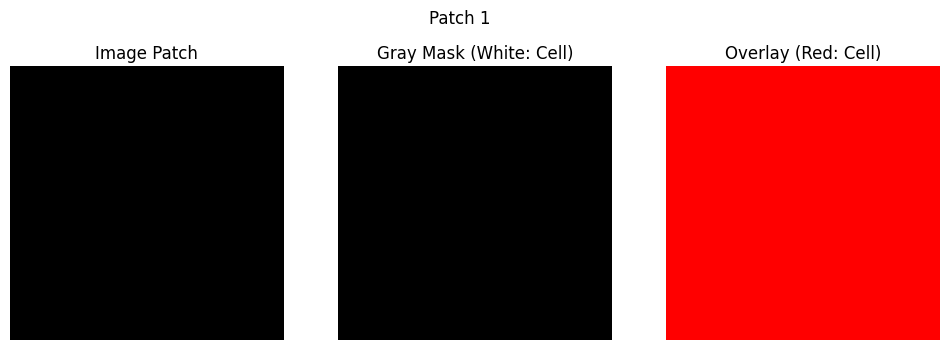

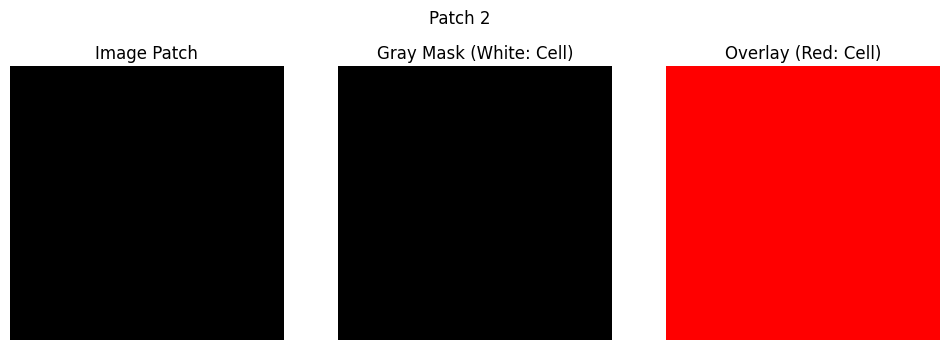

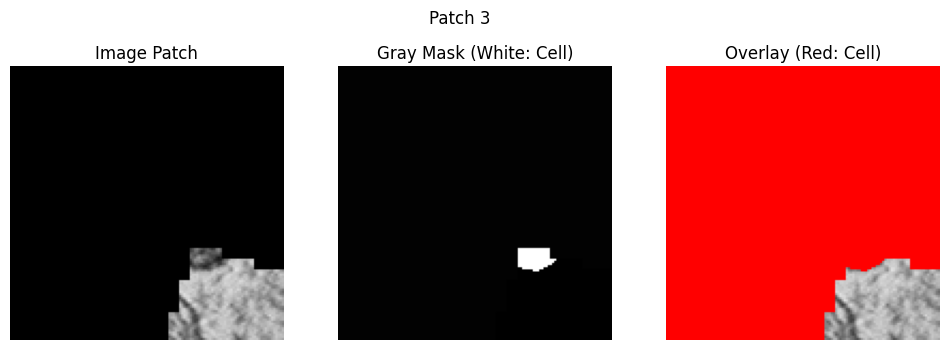

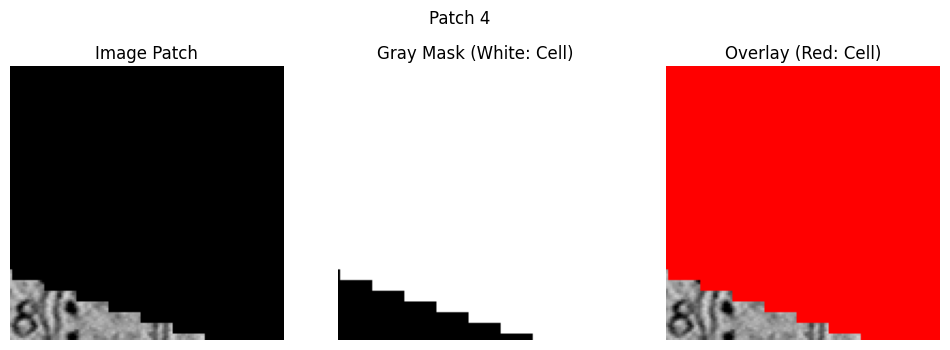

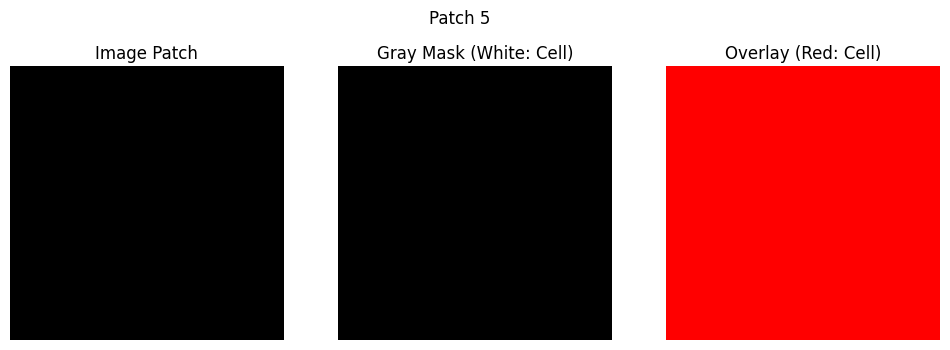

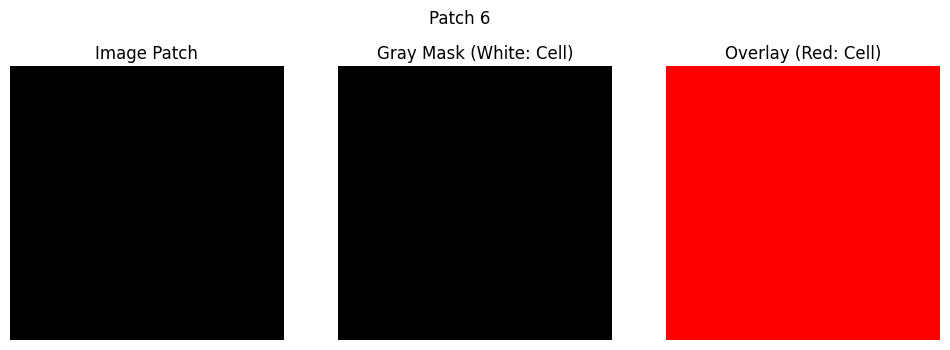

In [4]:
# 打印数据集基本信息
train_dataset.print_dataset_info()

# 随机查看几张图片的patches
train_dataset.visualize_random_images(num_images=1, patches_per_image=6)



In [ ]:

# 使用例子 model = UNet(num_classes=1).to(device)，下面是原注释

# Add reconstruction function
from functions.model import reconstruct_from_patches

# Training function
from functions.model import train_model

# Inference function
from functions.model import predict


In [ ]:
# Create datasets
# Create datasets and dataloaders
train_dataset = SegmentationDataset(train_data)
test_dataset = SegmentationDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(num_classes=1).to(device)

# Train model
train_model(model, train_loader, test_loader, num_epochs=50, device=device)







上面的测试： train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
patch_size=128, stride=64   


100%|██████████| 1702/1702 [21:33<00:00,  1.32it/s]
Epoch 1/50:
Train Loss: 0.0931, IoU: 0.7630, Dice: 0.8512
Val Loss: 0.0560, IoU: 0.7202, Dice: 0.8242
100%|██████████| 1702/1702 [30:43<00:00,  1.08s/it]
Epoch 2/50:
Train Loss: 0.0175, IoU: 0.9148, Dice: 0.9547
Val Loss: 0.0529, IoU: 0.7448, Dice: 0.8404
100%|██████████| 1702/1702 [30:27<00:00,  1.07s/it]
Epoch 3/50:
Train Loss: 0.0120, IoU: 0.9370, Dice: 0.9672
Val Loss: 0.0635, IoU: 0.7372, Dice: 0.8368

训练：
原始图像/掩码 -> 切分为128x128 patches(stride=64) -> 数据标准化(/255.0) -> 通道转换(HWC->CHW) -> 训练数据集构建
                                                                                                    ↓
                                                                                              模型训练循环
                                                                                                    ↓
                                                                                        保存最佳模型(IoU/Loss)

预测：
输入图像 -> 保持原始尺寸 -> 切分重叠patches(overlap=64) -> 数据标准化和通道转换 -> 模型预测
                                                                                    ↓
                                                            输出完整掩码 <- 加权重建 <- patch级预测结果


可使用counterbalance做对抗，train的部分需要在与处理下保证不同类的数据集特征倾向一致（这个之前没有做好导致泛化效率低）

首要目标：train和test的patch分割，都要使用patch进行，保证重叠度
         train部分的预处理操作不够完善（旋转和缩放没有设置，可能导致斜放图片以及比例不同的图片准确度下降），导致AB类数据集特征倾向不一致，泛化能力差
         后处理部分，目前只进行了形态学的消去小噪点，后续可以进行优化(打点，填充，闭运算等) 
         模块提取 后处理和预处理的内容
         还要加一个打点，这个可以去turnfinesam2那边找，记得把sam的内容也丢进来
        下面的是get point的方法，在 turnfinesam2_fix那边，要注意看！！！！把取点的后处理也拖动到unet中
         def get_points(mask, num_points):  # Sample points inside the input mask
            points = []
            coords = np.argwhere(mask > 0)
            for i in range(num_points):
                yx = np.array(coords[np.random.randint(len(coords))])
                points.append([[yx[1], yx[0]]])
            return np.array(points)
        这个函数可以随机选取mask中点，然后返回，这样偏差会小一些，记住！打点操作是后处理

准备尝试轻量化的数据测试，从1702降下来，看看整体效果，并且虽然加入了patch分割训练，但是还需要添加数据的预处理，比如颜色对比度的normalization，以及数据增强，还有对载入图片旋转训练（可以考虑加入其他数据进行验证，即Lucchi++和Kasthrui++混合训练），图像的后处理部分暂时可以先维持形态学的消去小噪点，后续再进行优化。

核心问题：model基础效果太差导致跨数据测试完全没效果，最大因素或许不在于size，而是颜色以及图片的细胞大小(即图片所占比例)，则测试准确度骤降，这点可以通过VNC和lucchi++数据集进行验证得到的，Lucchi model对VNC的测试甚至不如Kasthrui，但是看图片会发现虽然三类的数据集size都不一样，VNC颜色对比与K接近，而Lucchi偏向于浅色，这点也会影响模型的效果。


In [ ]:
# https://huggingface.co/CompVis/ldm-super-resolution-4x-openimages1
# Example inference
test_image_path = test_data[0]["image"]
pred_mask = predict(model, test_image_path)

# Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(cv2.imread(test_image_path))
plt.title('Original Image')
plt.subplot(132)
plt.imshow(cv2.imread(test_data[0]["annotation"], cv2.IMREAD_GRAYSCALE))
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(pred_mask)
plt.title('Prediction')
plt.show()

# Save model
torch.save(model.state_dict(), "overlaping_unet_segmentation_try.pth")



In [ ]:

# load from oxford_segmentation_models.pth
import torch

def load_model(model_path, num_classes, device):
    # Create an instance of your model
    model = SegmentationModel(num_classes)
    
    # Load the state dict
    state_dict = torch.load(model_path, map_location=device)
     
    # Load the state dict into your model
    model.load_state_dict(state_dict)
    
    # Move the model to the specified device
    model = model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 1 
model_path = "simple_unet_segmentation.pth"

model = load_model(model_path, num_classes, device)